## Setting up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit
import csv

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import logging
import geopandas as gpd
import xarray as xr
from shapely.geometry import shape
from rasterio import features
import config
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)

# in case no memory
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

custom_working_dir = '../../../data/OGGM/'

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
#rgi_df.set_index('rgi_id.v6', inplace=True)
rgi_df.head(2)

,short_name,full_name,sgi-id,rgi_id_v6_2016_shp,rgi_id.v6,rgi_id.v7,Issue
0,adler,Adler,B56-14,RGI60-11.B56-14,RGI60-11.02764,RGI2000-v7.0-G-11-01075,False
1,albigna,Albigna,C84-16,RGI60-11.C84-16,RGI60-11.02285,RGI2000-v7.0-G-11-02309,True


In [4]:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset_all.csv')
rgis = data_glamos.RGIId.unique()
data_glamos.head(2)

,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,286.843880,20.604390,3018.033333
1,2006,adler_54,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,258.181463,12.582387,3077.711111


In [5]:
# Load the shapefile
shapefile_path = "../../../data/GLAMOS/topo/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)

# Grid files
path_aspect = path_SGI_topo + 'aspect/'
path_slope = path_SGI_topo + 'slope/'
path_DEM = path_SGI_topo + 'dem_HR/'
path_outline = path_SGI_topo + 'outline/lv95/'

# Glacier ordered by name
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

glacier_alph = list(data_glamos.GLACIER.unique())
glacier_alph.remove('joeri')

print('Number of glaciers:', len(glacier_alph))
glacier_alph.sort()

# Order glaciers by size:
gl_area = {}
for glacierName in glacier_alph:
    if glacierName == 'clariden':
        sgi_id = rgi_df[rgi_df.short_name ==
                        'claridenU']['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         'claridenU']['rgi_id_v6_2016_shp'].values[0]
    else:
        sgi_id = rgi_df[rgi_df.short_name ==
                        glacierName]['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         glacierName]['rgi_id_v6_2016_shp'].values[0]

    # 2016 shapefile of glacier
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]
    gl_area[glacierName] = gdf_mask_gl.Area.values[0]

# sort by area (smallest first)
glacier_list = sorted(gl_area, key=lambda x: gl_area[x], reverse=False)
glacier_list

Number of glaciers: 31


['schwarzbach',
 'taelliboden',
 'pizol',
 'sanktanna',
 'corvatsch',
 'sexrouge',
 'murtel',
 'plattalva',
 'tortin',
 'basodino',
 'limmern',
 'adler',
 'hohlaub',
 'albigna',
 'tsanfleuron',
 'silvretta',
 'oberaar',
 'gries',
 'clariden',
 'gietro',
 'schwarzberg',
 'forno',
 'plainemorte',
 'allalin',
 'otemma',
 'findelen',
 'rhone',
 'morteratsch',
 'corbassiere',
 'gorner',
 'aletsch']

## SGI grids:

In [6]:
emptyfolder('figures/SGI_mask/')
for glacierName in tqdm(glacier_list):
    if glacierName == 'clariden':
        sgi_id = rgi_df[rgi_df.short_name ==
                        'claridenU']['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         'claridenU']['rgi_id_v6_2016_shp'].values[0]

    elif len(rgi_df[rgi_df.short_name == glacierName]['sgi-id']) == 0:
        print('No SGI ID found for', glacierName)
    else:
        sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0]
        sgi_id = sgi_id.strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         glacierName]['rgi_id_v6_2016_shp'].values[0]

    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]

    # open a grid file
    path_aspect = path_SGI_topo + 'aspect/'

    aspect_gl = [f for f in os.listdir(path_aspect) if sgi_id in f][0]
    metadata_aspect, grid_data_aspect = load_grid_file(path_aspect + aspect_gl)
    # convert to xarray
    aspect = convert_to_xarray_geodata(grid_data_aspect, metadata_aspect)
    # Transform the coordinates to WGS84
    aspect_wgs84 = transform_xarray_coords_lv95_to_wgs84(aspect)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    aspect_wgs84.plot(ax=ax)
    gdf_mask_gl.plot(ax=ax, alpha=0.5)

    # save figure
    plt.savefig('figures/SGI_mask/' + glacierName + '.png', dpi=300)
    plt.close()

  0%|          | 0/31 [00:00<?, ?it/s]

### Plot one mask over glacier outline:

Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(30.) x <xarray.DataArray 'y' ()> Size: 8B
array(30.) meters


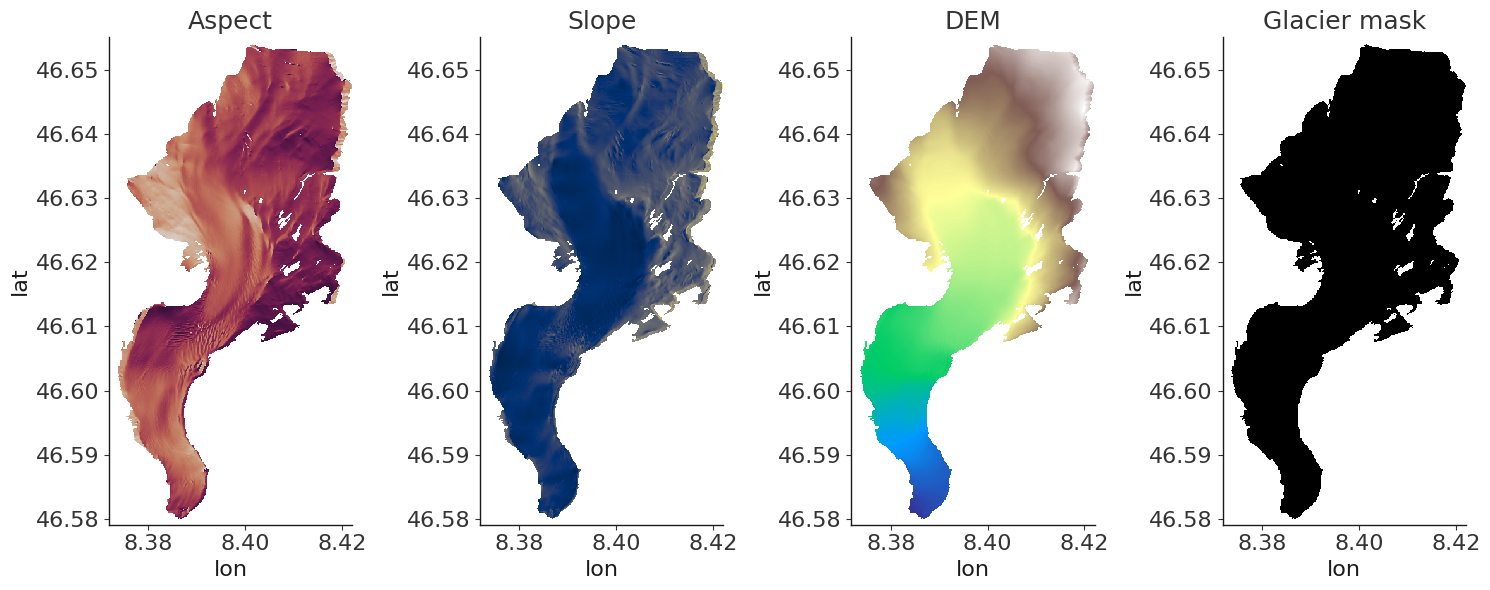

In [7]:
glacierName = 'rhone'
sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == glacierName]['rgi_id.v6'].values[0]
rgi_shp = rgi_df[rgi_df.short_name ==
                 glacierName]['rgi_id_v6_2016_shp'].values[0]
ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect, path_slope,
                        path_DEM, sgi_id)

# 2016 shapefile of glacier
gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
ds.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

ds = coarsenDS(ds, resampling_fac=3)

# Calculate resolution
dx = abs(ds.x[1] - ds.x[0])
dy = abs(ds.y[1] - ds.y[0])
print(f"Cell size: {dx} x {dy} meters")

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

### Compute for all glaciers with SGI:

In [8]:
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
voi_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
    "topo",
]

#### XR grids:

##### Check one grid:

Cell size of SGI: <xarray.DataArray 'x' ()> Size: 8B
array(10.) x <xarray.DataArray 'y' ()> Size: 8B
array(10.) meters
Cell size of OGGM: <xarray.DataArray 'x' ()> Size: 4B
array(66., dtype=float32) x <xarray.DataArray 'y' ()> Size: 4B
array(66., dtype=float32) meters
Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(10.) x <xarray.DataArray 'y' ()> Size: 8B
array(10.) meters


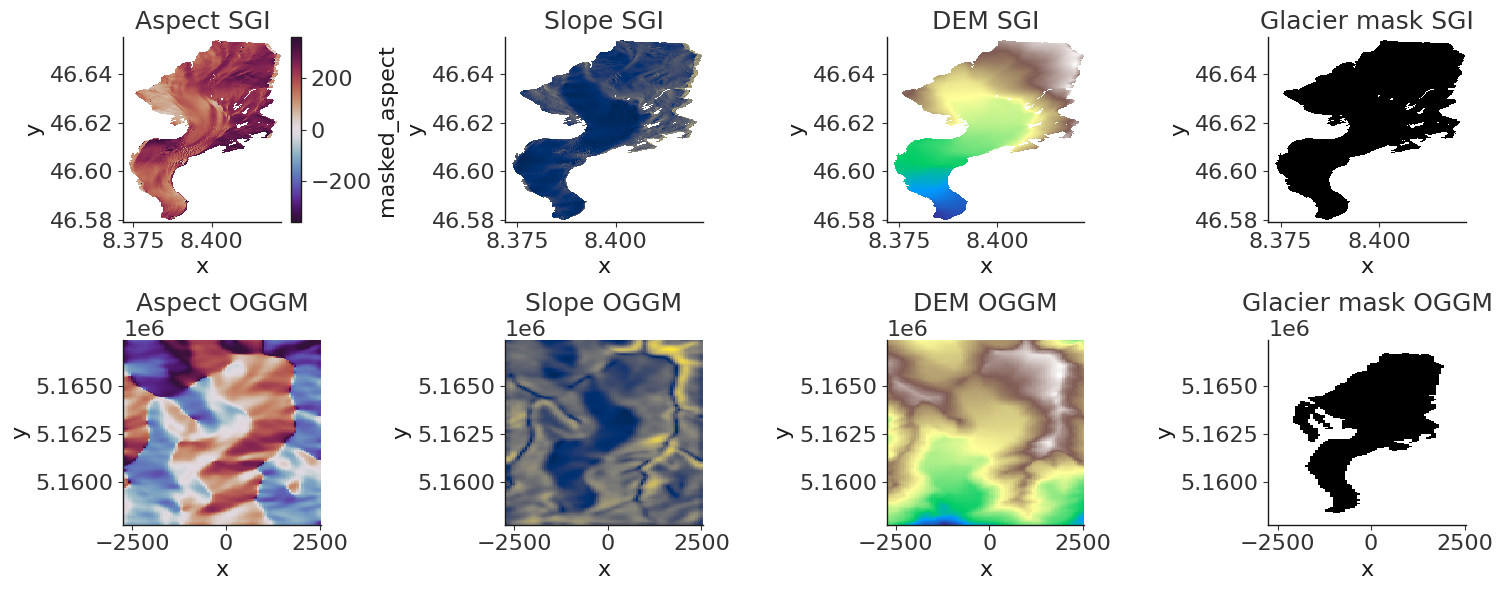

In [9]:
glacierName = 'rhone'
sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == glacierName]['rgi_id.v6'].values[0]
rgi_shp = rgi_df[rgi_df.short_name ==
                 glacierName]['rgi_id_v6_2016_shp'].values[0]

ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect, path_slope,
                        path_DEM, sgi_id)
# resolution of OGGM grid:
ds_oggm = xr.open_dataset(path_OGGM + f'xr_grids/{rgi_id}.nc')

# Calculate resolution
dx = abs(ds.x[1] - ds.x[0])
dy = abs(ds.y[1] - ds.y[0])
print(f"Cell size of SGI: {dx} x {dy} meters")

# OGGM
dx = abs(ds_oggm.x[1] - ds_oggm.x[0])
dy = abs(ds_oggm.y[1] - ds_oggm.y[0])
print('Cell size of OGGM:', dx, 'x', dy, 'meters')

# Plot the masked data
fig, axs = plt.subplots(2, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0, 0], cmap='twilight_shifted')
ds.masked_slope.plot(ax=axs[0, 1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[0, 2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[0, 3], cmap='binary', add_colorbar=False)

axs[0, 0].set_title("Aspect SGI")
axs[0, 1].set_title("Slope SGI")
axs[0, 2].set_title("DEM SGI")
axs[0, 3].set_title("Glacier mask SGI")

# Add a second row with the OGGM data
ds_oggm.aspect.plot(ax=axs[1, 0], cmap='twilight_shifted', add_colorbar=False)
ds_oggm.slope.plot(ax=axs[1, 1], cmap='cividis', add_colorbar=False)
ds_oggm.topo.plot(ax=axs[1, 2], cmap='terrain', add_colorbar=False)
ds_oggm.glacier_mask.plot(ax=axs[1, 3], cmap='binary', add_colorbar=False)

# set x and y labels
for ax in axs.flatten():
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend().remove()
axs[1, 0].set_title("Aspect OGGM")
axs[1, 1].set_title("Slope OGGM")
axs[1, 2].set_title("DEM OGGM")
axs[1, 3].set_title("Glacier mask OGGM")
plt.tight_layout()

# Calculate resolution
dx = abs(ds.x[1] - ds.x[0])
dy = abs(ds.y[1] - ds.y[0])
print(f"Cell size: {dx} x {dy} meters")

Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(30.) x <xarray.DataArray 'y' ()> Size: 8B
array(30.) meters


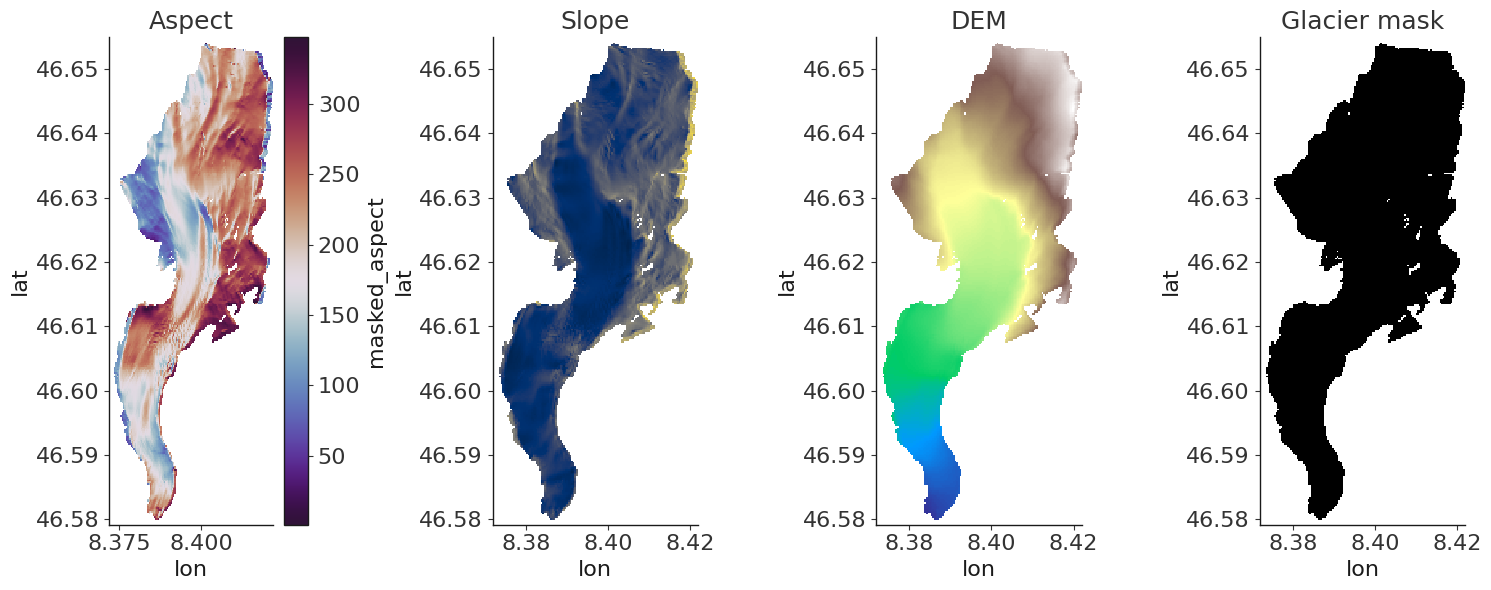

In [10]:
# Resample SGI grid:
# Coarson to 30 m resolution
ds_resampled = coarsenDS(ds)

# Calculate resolution
dx = abs(ds_resampled.x[1] - ds_resampled.x[0])
dy = abs(ds_resampled.y[1] - ds_resampled.y[0])
print(f"Cell size: {dx} x {dy} meters")

# Plot resampled grid
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_resampled.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_resampled.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds_resampled.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds_resampled.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

##### Save all xr grids:

In [11]:
path_save = path_SGI_topo + 'xr_masked_grids/'
emptyfolder(path_save)
for glacierName in tqdm(glacier_list):
    if glacierName == 'clariden':
        sgi_id = rgi_df[rgi_df.short_name ==
                        'claridenU']['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         'claridenU']['rgi_id_v6_2016_shp'].values[0]
    else:
        sgi_id = rgi_df[rgi_df.short_name ==
                        glacierName]['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         glacierName]['rgi_id_v6_2016_shp'].values[0]

    ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect, path_slope,
                            path_DEM, sgi_id)
    # Coarson to 30 m resolution
    ds_resampled = coarsenDS(ds)

    # save xr dataset
    ds_resampled.to_netcdf(path_save + glacierName + '.nc')

  0%|          | 0/31 [00:00<?, ?it/s]

#### Monthly DF grids:

In [12]:
glacier_shp_rgi6 = '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'
glacier_outline = gpd.read_file(glacier_shp_rgi6)

##### Example of one glacier:

In [13]:
glacierName = 'rhone'
year = 2010
sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == glacierName]['rgi_id.v6'].values[0]
rgi_shp = rgi_df[rgi_df.short_name ==
                 glacierName]['rgi_id_v6_2016_shp'].values[0]

# Load SGI masked grid
ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect, path_slope,
                        path_DEM, sgi_id)

# Coarson to 30 m resolution
ds_coarsend = coarsenDS(ds)

# Create glacier grid
df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id, ds_coarsend)
df_grid.reset_index(drop=True, inplace=True)
dataset_grid = mbm.Dataset(data=df_grid,
                           region_name='CH',
                           data_path=path_PMB_GLAMOS_csv)

# Add climate data:
print('DF grid shape:', df_grid.shape)
print('Adding climate data:')
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                  geopotential_data=geopotential_data,
                                  change_units=True)

# Add potential clear sky radiation:
print('Adding potential clear sky radiation:')
dataset_grid.get_potential_rad(path_direct_save)

# Add OGGM data:
print('Adding OGGM data:')
df_y_gl = dataset_grid.data
df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

# Add RGI IDs through intersection with shapefiles:
df_y_gl = mbm.data_processing.utils.get_rgi(data=df_y_gl,
                                            glacier_outlines=glacier_outline)

# Drop points without RGI ID:
df_y_gl = df_y_gl.dropna(subset=['RGIId'])

# Variables of interest
voi = [
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
dataset_grid = mbm.Dataset(data=df_y_gl,
                           region_name='CH',
                           data_path=path_PMB_GLAMOS_csv)

DF grid shape: (16840, 15)
Adding climate data:
Adding potential clear sky radiation:
Adding OGGM data:


##### For all months:

In [14]:
def find_processed_and_incomplete_glaciers(folder_path, all_glaciers):
    """
    Identifies glaciers that are fully processed and those with missing years.

    Parameters:
        folder_path (str): Path to the folder containing the files.
        all_glaciers (list): List of all glaciers that need to be processed.

    Returns:
        tuple: A list of fully processed glaciers and a dictionary of incomplete glaciers with missing years.
    """
    processed_years = defaultdict(set)

    # Regular expression to match the filename format
    pattern = re.compile(
        r'^(?P<glacier>[a-zA-Z_]+)_grid_(?P<year>\d{4})\.csv$')

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            glacier = match.group('glacier')
            year = int(match.group('year'))
            if 2000 <= year <= 2023:
                processed_years[glacier].add(year)

    fully_processed = []
    incomplete_glaciers = {}

    # Check for completeness for each glacier
    for glacier in all_glaciers:
        all_years = set(range(2000, 2024))
        if glacier in processed_years:
            missing_years = all_years - processed_years[glacier]
            if not missing_years:
                fully_processed.append(glacier)
            else:
                incomplete_glaciers[glacier] = sorted(missing_years)
        else:
            incomplete_glaciers[glacier] = sorted(all_years)

    return fully_processed, incomplete_glaciers


fully_processed, incomplete_glaciers = find_processed_and_incomplete_glaciers(
    path_glacier_grid_sgi, glacier_list)
fully_processed, incomplete_glaciers

(['schwarzbach',
  'taelliboden',
  'pizol',
  'sanktanna',
  'corvatsch',
  'sexrouge',
  'murtel',
  'plattalva',
  'tortin',
  'basodino',
  'limmern',
  'adler',
  'hohlaub',
  'albigna',
  'tsanfleuron',
  'silvretta',
  'oberaar',
  'gries',
  'clariden',
  'gietro',
  'schwarzberg',
  'forno',
  'plainemorte',
  'allalin',
  'otemma',
  'findelen',
  'rhone',
  'morteratsch',
  'corbassiere',
  'gorner',
  'aletsch'],
 {})

In [15]:
RUN = False
if RUN:
    # emptyfolder(path_glacier_grid_sgi)
    # Glaciers used for testing
    for glacierName in tqdm(incomplete_glaciers.keys(),
                            desc='Processing glaciers'):
        print('\n-----------------------------------')
        print(glacierName)
        for year in tqdm(incomplete_glaciers[glacierName], desc='Years'):
            if glacierName == 'clariden':
                sgi_id = rgi_df[rgi_df.short_name ==
                                'claridenU']['sgi-id'].values[0].strip()
                rgi_shp = rgi_df[rgi_df.short_name ==
                                 'claridenU']['rgi_id_v6_2016_shp'].values[0]
                rgi_id = rgi_df[rgi_df.short_name ==
                                'claridenU']['rgi_id.v6'].values[0]
            else:
                sgi_id = rgi_df[rgi_df.short_name ==
                                glacierName]['sgi-id'].values[0].strip()
                rgi_id = rgi_df[rgi_df.short_name ==
                                glacierName]['rgi_id.v6'].values[0]
                rgi_shp = rgi_df[rgi_df.short_name ==
                                 glacierName]['rgi_id_v6_2016_shp'].values[0]

            # Load SGI masked grid
            ds = xr_SGI_masked_topo(rgi_shp, gdf_shapefiles, path_aspect,
                                    path_slope, path_DEM, sgi_id)

            # Coarson to 30 m resolution
            ds_coarsend = coarsenDS(ds)

            # Create glacier grid
            df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id,
                                              ds_coarsend)
            df_grid.reset_index(drop=True, inplace=True)
            dataset_grid = mbm.Dataset(data=df_grid,
                                       region_name='CH',
                                       data_path=path_PMB_GLAMOS_csv)

            # Add climate data:
            if year == 2000:
                print('DF grid shape:', df_grid.shape)
                print('Adding climate data:')
            era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
            geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
            dataset_grid.get_climate_features(
                climate_data=era5_climate_data,
                geopotential_data=geopotential_data,
                change_units=True)

            # Add potential clear sky radiation:
            if year == 2000: print('Adding potential clear sky radiation:')
            dataset_grid.get_potential_rad(path_direct_save)

            # Add OGGM data:
            if year == 2000: print('Adding OGGM data:')
            df_y_gl = dataset_grid.data
            df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

            # Add RGI IDs through intersection with shapefiles:
            df_y_gl = mbm.data_processing.utils.get_rgi(
                data=df_y_gl, glacier_outlines=glacier_outline)

            # Drop points without RGI ID:
            df_y_gl = df_y_gl.dropna(subset=['RGIId'])

            # Variables of interest
            voi = [
                "hugonnet_dhdt",
                "consensus_ice_thickness",
                "millan_v",
            ]

            df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
            dataset_grid = mbm.Dataset(data=df_y_gl,
                                       region_name='CH',
                                       data_path=path_PMB_GLAMOS_csv)

            # For each record, convert to a monthly time resolution
            if year == 2000:
                print('Converting to monthly time resolution:')

            dataset_grid.convert_to_monthly(
                meta_data_columns=config.META_DATA,
                vois_climate=vois_climate + ['pcsr'],
                vois_topographical=voi_topographical)
            assert ('pcsr' in dataset_grid.data.columns)
            if year == 2000: print('DF grid shape:', dataset_grid.data.shape)

            # Save gridded dataset:
            if year == 2000:
                print('Saving gridded dataset')
            dataset_grid.data.to_csv(path_glacier_grid_sgi +
                                     f'{glacierName}_grid_{year}.csv',
                                     index=False)

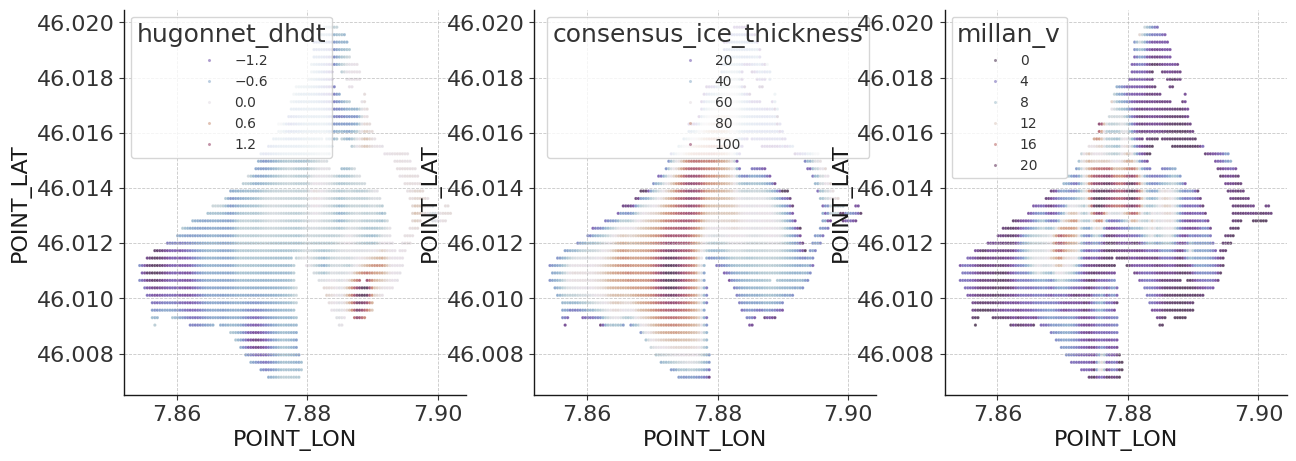

In [16]:
# Plot all OGGM variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
df = pd.read_csv(path_glacier_grid_sgi + 'adler_grid_2000.csv')
df = df[df.MONTHS == 'sep']
for i, var in enumerate(voi):
    sns.scatterplot(df,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=5,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])

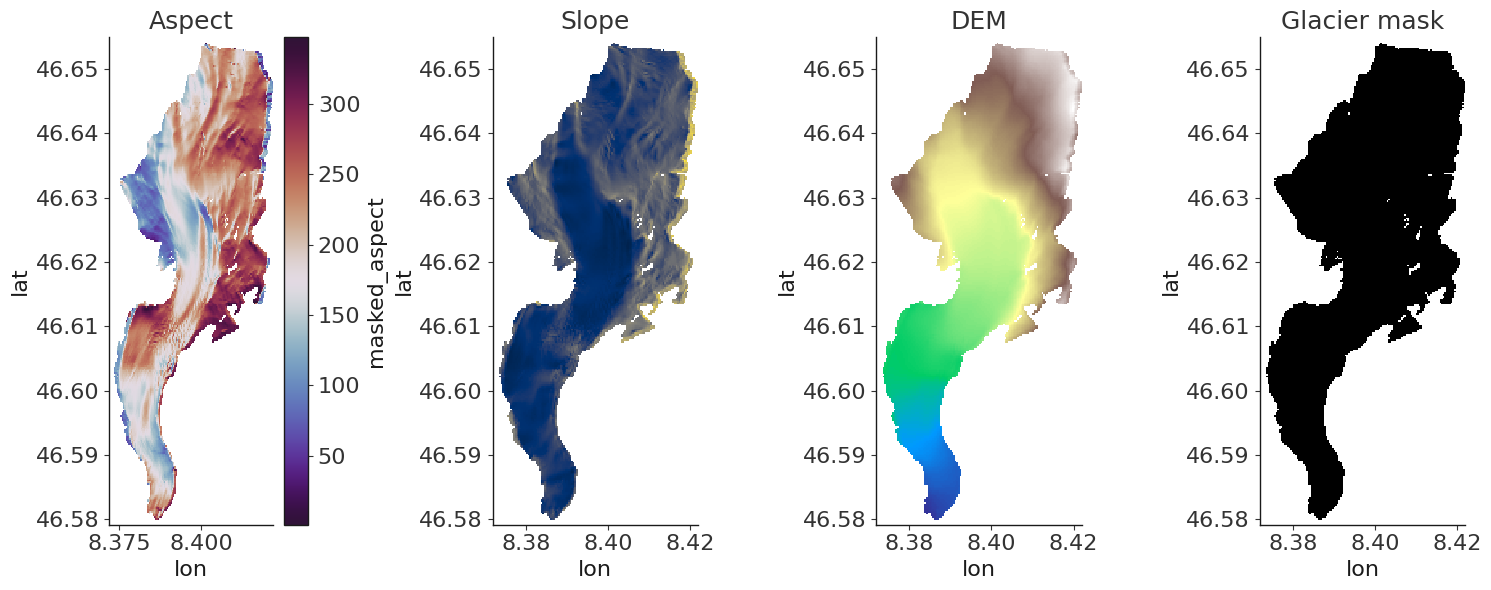

In [17]:
# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_coarsend.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted')
ds_coarsend.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds_coarsend.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds_coarsend.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

In [18]:
# With OGGM data:
# # Load stake data for that glacier
# data_gl = data_glamos[data_glamos.RGIId == rgi_id]
# dataset_gl = mbm.Dataset(data=data_gl,
#                             region_name='CH',
#                             data_path=path_PMB_GLAMOS_csv)

# # Get gridded glacier data from OGGM
# df_grid = dataset_gl.create_glacier_grid(custom_working_dir)
# df_grid["PERIOD"] = "annual"
# df_grid['GLACIER'] = glacierName
# df_grid.shape

## Yearly GLAMOS grids:

### Example of one glacier:

[1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(25.) x <xarray.DataArray 'y' ()> Size: 8B
array(25.) meters
Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(33.33333333) x <xarray.DataArray 'y' ()> Size: 8B
array(33.33333333) meters


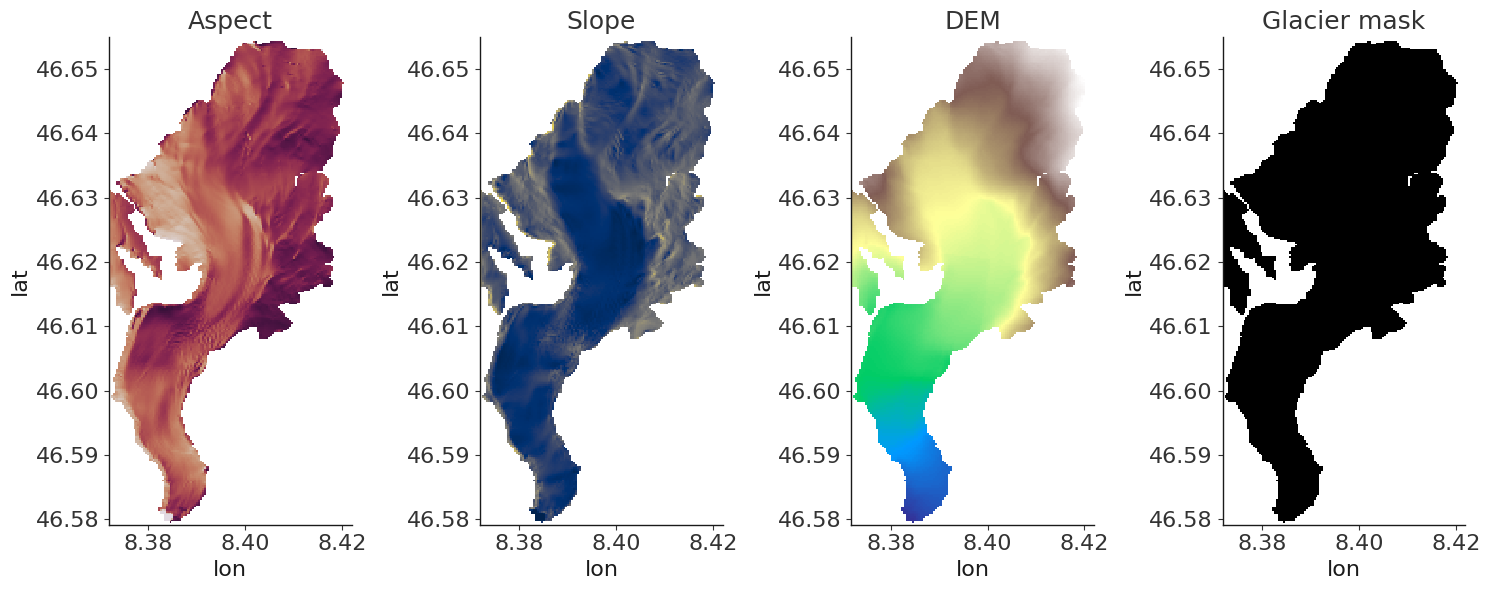

In [19]:
glacierName = 'rhone'
sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == glacierName]['rgi_id.v6'].values[0]
rgi_shp = rgi_df[rgi_df.short_name ==
                 glacierName]['rgi_id_v6_2016_shp'].values[0]

path_GLAMOS_topo = '../../../data/GLAMOS/topo/GLAMOS_DEM/lv95/'
gl_yearly = os.listdir(path_GLAMOS_topo)

folder_path = path_GLAMOS_topo + glacierName
# Regular expression to extract years from filenames
pattern = re.compile(r'gl_(\d{4})_lv95\.grid')
# pattern = re.compile(r'gl_(\d{4})\.grid')

# Extract years from filenames
years = set()
for filename in os.listdir(folder_path):
    match = pattern.match(filename)
    if match:
        years.add(int(match.group(1)))

# Sort and display the years
sorted_years = sorted(years)
print(sorted_years)

fileName = 'gl_2013_lv95.grid'
metadata, grid_data = load_grid_file(folder_path + '/' + fileName)

# convert to xarray
dem_y = convert_to_xarray_geodata(grid_data, metadata)
# Transform the coordinates to WGS84
dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

# Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
ds_gl = xr.Dataset({'dem': dem_wgs84_y})
ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

# Calculate resolution
dx = abs(ds_gl.x[1] - ds_gl.x[0])
dy = abs(ds_gl.y[1] - ds_gl.y[0])
print(f"Cell size: {dx} x {dy} meters")

ds = xr_GLAMOS_masked_topo(path_aspect, path_slope, sgi_id, ds_gl)

# Coarson to 30 m resolution
ds = coarsenDS(ds)

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds.masked_aspect.plot(ax=axs[0], cmap='twilight_shifted', add_colorbar=False)
ds.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

# Calculate resolution
dx = abs(ds.x[1] - ds.x[0])
dy = abs(ds.y[1] - ds.y[0])
print(f"Cell size: {dx} x {dy} meters")

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

### Save all xr grids:

In [22]:
path_xr_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'
RUN = False
if RUN:
    emptyfolder(path_xr_grids)
    for glacierName in tqdm(glacier_list):
        print(glacierName)

        if glacierName == 'clariden':
            sgi_id = rgi_df[rgi_df.short_name ==
                            'claridenU']['sgi-id'].values[0].strip()
            rgi_shp = rgi_df[rgi_df.short_name ==
                            'claridenU']['rgi_id_v6_2016_shp'].values[0]
        else:
            sgi_id = rgi_df[rgi_df.short_name ==
                            glacierName]['sgi-id'].values[0].strip()
            rgi_shp = rgi_df[rgi_df.short_name ==
                            glacierName]['rgi_id_v6_2016_shp'].values[0]
        
        if glacierName == 'sanktanna':
            folder_path = path_GLAMOS_topo + 'stanna'
        else:
            folder_path = path_GLAMOS_topo + glacierName
            
        # if folder does not exist:
        if not os.path.exists(folder_path):
            print('Folder does not exist:', folder_path)
            continue

        # Regular expression to extract years from filenames
        pattern = re.compile(r'gl_(\d{4})_lv95\.grid')

        # Extract years from filenames
        years = set()
        for filename in os.listdir(folder_path):
            match = pattern.match(filename)
            if match:
                years.add(int(match.group(1)))

        # Sort and display the years
        sorted_years = sorted(years)

        for year in tqdm(sorted_years, leave = False, dec = 'Years'):
            # if year < 2000:
            #     continue

            fileName = f'gl_{year}_lv95.grid'
            metadata, grid_data = load_grid_file(folder_path + '/' + fileName)

            # convert to xarray
            dem_y = convert_to_xarray_geodata(grid_data, metadata)

            # Transform the coordinates to WGS84
            dem_wgs84_y = transform_xarray_coords_lv95_to_wgs84(dem_y)

            # Create a mask where 'elevation' is not NaN (1 if not NaN, 0 if NaN)
            ds_gl = xr.Dataset({'dem': dem_wgs84_y})
            ds_gl["glacier_mask"] = ds_gl["dem"].notnull().astype(np.uint8)

            ds = xr_GLAMOS_masked_topo(path_aspect, path_slope, sgi_id, ds_gl)

            # Coarson to 30 m resolution
            ds = coarsenDS(ds)

            # save xr dataset
            ds.to_netcdf(path_xr_grids + glacierName + f'_{year}.nc')

  0%|          | 0/31 [00:00<?, ?it/s]

schwarzbach
taelliboden
pizol
sanktanna
corvatsch
sexrouge
murtel
plattalva
tortin
basodino
limmern
adler
hohlaub
albigna
tsanfleuron
silvretta
oberaar
gries
clariden
gietro
schwarzberg
forno
plainemorte
allalin
otemma
findelen
rhone
morteratsch
Folder does not exist: ../../../data/GLAMOS/topo/GLAMOS_DEM/lv95/morteratsch
corbassiere
gorner
Folder does not exist: ../../../data/GLAMOS/topo/GLAMOS_DEM/lv95/gorner
aletsch


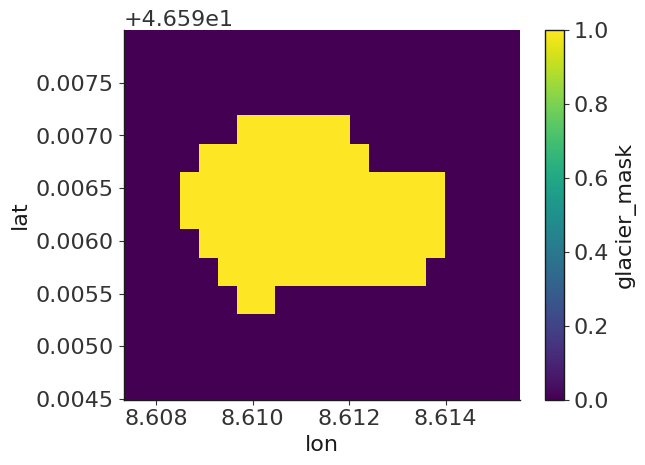

In [23]:
# open an example grid file
ds = xr.open_dataset(path_xr_grids + 'schwarzbach_2015.nc')
ds.glacier_mask.plot()


### Monthly DFs for MBM:

Cell size: <xarray.DataArray 'x' ()> Size: 8B
array(33.33333333) x <xarray.DataArray 'y' ()> Size: 8B
array(33.33333333) meters


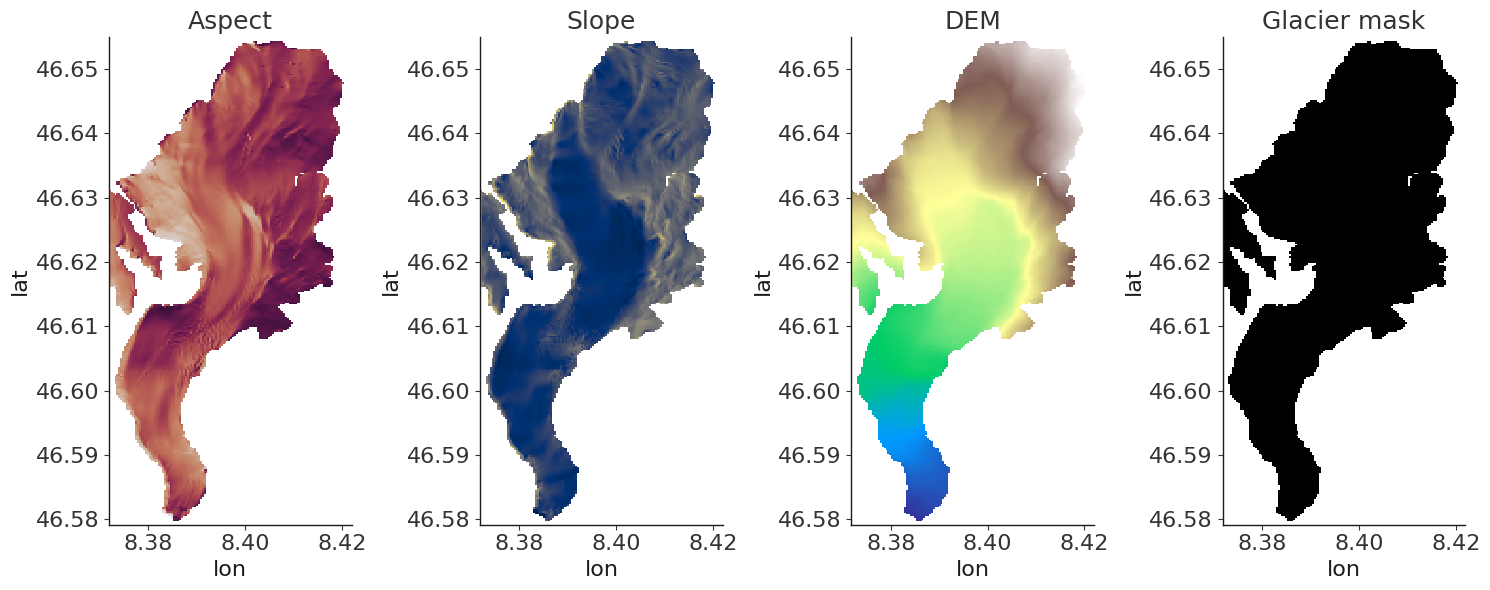

In [24]:
glacierName = 'rhone'
year = 2015
path_xr_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'

sgi_id = rgi_df[rgi_df.short_name == glacierName]['sgi-id'].values[0].strip()
rgi_id = rgi_df[rgi_df.short_name == glacierName]['rgi_id.v6'].values[0]
rgi_shp = rgi_df[rgi_df.short_name ==
                 glacierName]['rgi_id_v6_2016_shp'].values[0]

fileName = f'{glacierName}_{year}.nc'
ds_coarsened = xr.open_dataset(path_xr_grids + fileName)

# Plot the masked data
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
ds_coarsened.masked_aspect.plot(ax=axs[0],
                                cmap='twilight_shifted',
                                add_colorbar=False)
ds_coarsened.masked_slope.plot(ax=axs[1], cmap='cividis', add_colorbar=False)
ds_coarsened.masked_elev.plot(ax=axs[2], cmap='terrain', add_colorbar=False)
ds_coarsened.glacier_mask.plot(ax=axs[3], cmap='binary', add_colorbar=False)

# Calculate resolution
dx = abs(ds_coarsened.x[1] - ds_coarsened.x[0])
dy = abs(ds_coarsened.y[1] - ds_coarsened.y[0])
print(f"Cell size: {dx} x {dy} meters")

axs[0].set_title("Aspect")
axs[1].set_title("Slope")
axs[2].set_title("DEM")
axs[3].set_title("Glacier mask")
plt.tight_layout()

DF grid shape: (17467, 15)
Adding climate data:
Adding potential clear sky radiation:
Adding OGGM data:


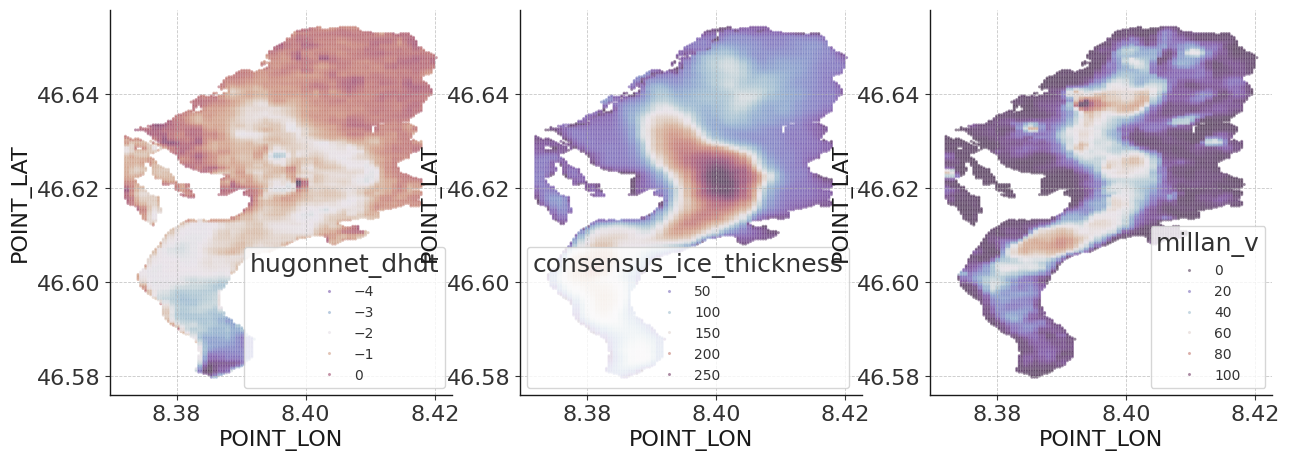

In [25]:
# Create glacier grid
df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id, ds_coarsened)
df_grid.reset_index(drop=True, inplace=True)
dataset_grid = mbm.Dataset(data=df_grid,
                           region_name='CH',
                           data_path=path_PMB_GLAMOS_csv)

# Add climate data:
print('DF grid shape:', df_grid.shape)
print('Adding climate data:')
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                  geopotential_data=geopotential_data,
                                  change_units=True)

# Add potential clear sky radiation:
print('Adding potential clear sky radiation:')
dataset_grid.get_potential_rad(path_direct_save)

# Add OGGM data:
print('Adding OGGM data:')
df_y_gl = dataset_grid.data
df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

# Add RGI IDs through intersection with shapefiles:
df_y_gl = mbm.data_processing.utils.get_rgi(data=df_y_gl,
                                            glacier_outlines=glacier_outline)

# Drop points without RGI ID:
df_y_gl = df_y_gl.dropna(subset=['RGIId'])

# Variables of interest
voi = [
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
dataset_grid = mbm.Dataset(data=df_y_gl,
                           region_name='CH',
                           data_path=path_PMB_GLAMOS_csv)

# Plot all OGGM variables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, var in enumerate(voi):
    sns.scatterplot(df_y_gl,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=5,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])

#### All months:

In [27]:
path_glacier_grid_glamos = '../../../data/GLAMOS/topo/gridded_topo_inputs/GLAMOS_yearly/'
path_xr_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # previously created

processed_gl = np.unique([re.split('_', f)[0] for f in os.listdir(path_glacier_grid_glamos)])
remaining_gl = Diff(list(glacier_list), list(processed_gl))
remaining_gl

##### Years above 2000 (already computed):

In [ ]:

RUN = True
if RUN:
    #emptyfolder(path_glacier_grid_glamos)
    for glacierName in tqdm(remaining_gl, desc='Processing glaciers'): 
        # all files with that glacier in path
        files = [f for f in os.listdir(path_xr_grids) if glacierName in f]
        print(glacierName, files)
        for fileName in tqdm(files, desc='files', leave = False):
            year = int(fileName.split('_')[1].split('.')[0])
            if glacierName == 'clariden':
                sgi_id = rgi_df[rgi_df.short_name ==
                                'claridenU']['sgi-id'].values[0].strip()
                rgi_shp = rgi_df[rgi_df.short_name ==
                                'claridenU']['rgi_id_v6_2016_shp'].values[0]
                rgi_id = rgi_df[rgi_df.short_name ==
                                'claridenU']['rgi_id.v6'].values[0]
            else:
                sgi_id = rgi_df[rgi_df.short_name ==
                                glacierName]['sgi-id'].values[0].strip()
                rgi_id = rgi_df[rgi_df.short_name ==
                                glacierName]['rgi_id.v6'].values[0]
                rgi_shp = rgi_df[rgi_df.short_name ==
                                glacierName]['rgi_id_v6_2016_shp'].values[0]

            # Load GLAMOS masked grid
            ds = xr.open_dataset(path_xr_grids + fileName)

            # Create glacier grid
            df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id,
                                            ds)
            df_grid.reset_index(drop=True, inplace=True)
            dataset_grid = mbm.Dataset(data=df_grid,
                                    region_name='CH',
                                    data_path=path_PMB_GLAMOS_csv)

            # Add climate data:
            era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
            geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
            dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                            geopotential_data=geopotential_data,
                                            change_units=True)

            # Add potential clear sky radiation:
            dataset_grid.get_potential_rad(path_direct_save)

            # Add OGGM data:
            df_y_gl = dataset_grid.data
            df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

            # Add RGI IDs through intersection with shapefiles:
            df_y_gl = mbm.data_processing.utils.get_rgi(
                data=df_y_gl, glacier_outlines=glacier_outline)

            # Drop points without RGI ID:
            df_y_gl = df_y_gl.dropna(subset=['RGIId'])

            # Variables of interest
            voi = [
                "hugonnet_dhdt",
                "consensus_ice_thickness",
                "millan_v",
            ]

            df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
            dataset_grid = mbm.Dataset(data=df_y_gl,
                                    region_name='CH',
                                    data_path=path_PMB_GLAMOS_csv)

            dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                            vois_climate=vois_climate + ['pcsr'],
                                            vois_topographical=voi_topographical)
            assert ('pcsr' in dataset_grid.data.columns)

            dataset_grid.data.to_csv(path_glacier_grid_glamos +
                                    f'{glacierName}_grid_{year}.csv',
                                    index=False)

##### Years below 2000: (TBD)

In [29]:
RUN = True
if RUN:
    #emptyfolder(path_glacier_grid_glamos)
    # Glaciers used for testing
    # for fileName in tqdm(os.listdir(path_xr_grids),
    #                      desc='Processing glaciers'):
    #     glacierName = fileName.split('_')[0]
    remaining_gl = os.listdir('../../../data/GLAMOS/topo/GLAMOS_DEM/lv95/')
    for glacierName in tqdm(remaining_gl, desc='Processing glaciers'): 
        # all files with that glacier in path
        files = [f for f in os.listdir(path_xr_grids) if glacierName in f]
        print(glacierName, files)
        for fileName in tqdm(files, desc='files', leave = False):
            year = int(fileName.split('_')[1].split('.')[0])
            if year > 2000 or year < 1951:
                continue
            
            if glacierName == 'clariden':
                sgi_id = rgi_df[rgi_df.short_name ==
                                'claridenU']['sgi-id'].values[0].strip()
                rgi_shp = rgi_df[rgi_df.short_name ==
                                'claridenU']['rgi_id_v6_2016_shp'].values[0]
                rgi_id = rgi_df[rgi_df.short_name ==
                                'claridenU']['rgi_id.v6'].values[0]
            else:
                sgi_id = rgi_df[rgi_df.short_name ==
                                glacierName]['sgi-id'].values[0].strip()
                rgi_id = rgi_df[rgi_df.short_name ==
                                glacierName]['rgi_id.v6'].values[0]
                rgi_shp = rgi_df[rgi_df.short_name ==
                                glacierName]['rgi_id_v6_2016_shp'].values[0]

            # Load GLAMOS masked grid
            ds = xr.open_dataset(path_xr_grids + fileName)

            # Create glacier grid
            df_grid = create_glacier_grid_SGI(glacierName, year, rgi_id,
                                            ds)
            df_grid.reset_index(drop=True, inplace=True)
            dataset_grid = mbm.Dataset(data=df_grid,
                                    region_name='CH',
                                    data_path=path_PMB_GLAMOS_csv)

            # Add climate data:
            era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
            geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'
            dataset_grid.get_climate_features(climate_data=era5_climate_data,
                                            geopotential_data=geopotential_data,
                                            change_units=True)

            # Add potential clear sky radiation:
            dataset_grid.get_potential_rad(path_direct_save)

            # Add OGGM data:
            df_y_gl = dataset_grid.data
            df_y_gl.rename(columns={'RGIId': 'RGIId_old'}, inplace=True)

            # Add RGI IDs through intersection with shapefiles:
            df_y_gl = mbm.data_processing.utils.get_rgi(
                data=df_y_gl, glacier_outlines=glacier_outline)

            # Drop points without RGI ID:
            df_y_gl = df_y_gl.dropna(subset=['RGIId'])

            # Variables of interest
            voi = [
                "hugonnet_dhdt",
                "consensus_ice_thickness",
                "millan_v",
            ]

            df_y_gl = add_OGGM_features(df_y_gl, voi, path_OGGM)
            dataset_grid = mbm.Dataset(data=df_y_gl,
                                    region_name='CH',
                                    data_path=path_PMB_GLAMOS_csv)

            dataset_grid.convert_to_monthly(meta_data_columns=config.META_DATA,
                                            vois_climate=vois_climate + ['pcsr'],
                                            vois_topographical=voi_topographical)
            assert ('pcsr' in dataset_grid.data.columns)

            dataset_grid.data.to_csv(path_glacier_grid_glamos +
                                    f'{glacierName}_grid_{year}.csv',
                                    index=False)

Processing glaciers:   0%|          | 0/38 [00:00<?, ?it/s]

chessjen []


files: 0it [00:00, ?it/s]

plattalva ['plattalva_1964.nc', 'plattalva_1981.nc', 'plattalva_1954.nc', 'plattalva_1971.nc', 'plattalva_1958.nc', 'plattalva_1985.nc', 'plattalva_1967.nc', 'plattalva_1984.nc', 'plattalva_1960.nc', 'plattalva_1955.nc', 'plattalva_1977.nc', 'plattalva_1978.nc', 'plattalva_1975.nc', 'plattalva_1979.nc', 'plattalva_1959.nc', 'plattalva_1953.nc', 'plattalva_1948.nc', 'plattalva_1965.nc', 'plattalva_1957.nc', 'plattalva_1983.nc', 'plattalva_1951.nc', 'plattalva_1962.nc', 'plattalva_1949.nc', 'plattalva_1963.nc', 'plattalva_1956.nc', 'plattalva_1982.nc', 'plattalva_1974.nc', 'plattalva_1980.nc', 'plattalva_1950.nc', 'plattalva_1970.nc', 'plattalva_1973.nc', 'plattalva_1976.nc', 'plattalva_1966.nc', 'plattalva_1952.nc', 'plattalva_1961.nc', 'plattalva_1968.nc', 'plattalva_1972.nc', 'plattalva_1969.nc']


files:   0%|          | 0/38 [00:00<?, ?it/s]

gries ['gries_2013.nc', 'gries_2015.nc', 'gries_2019.nc', 'gries_1968.nc', 'gries_2024.nc', 'gries_1975.nc', 'gries_1962.nc', 'gries_2005.nc', 'gries_2022.nc', 'gries_1971.nc', 'gries_1966.nc', 'gries_2002.nc', 'gries_1984.nc', 'gries_1993.nc', 'gries_1964.nc', 'gries_1989.nc', 'gries_1980.nc', 'gries_1978.nc', 'gries_2016.nc', 'gries_1998.nc', 'gries_1987.nc', 'gries_2001.nc', 'gries_2014.nc', 'gries_2010.nc', 'gries_1976.nc', 'gries_1988.nc', 'gries_1963.nc', 'gries_2018.nc', 'gries_1985.nc', 'gries_1995.nc', 'gries_2004.nc', 'gries_1972.nc', 'gries_2006.nc', 'gries_1967.nc', 'gries_2021.nc', 'gries_1969.nc', 'gries_1997.nc', 'gries_1983.nc', 'gries_1974.nc', 'gries_1982.nc', 'gries_2017.nc', 'gries_1999.nc', 'gries_1986.nc', 'gries_1973.nc', 'gries_1981.nc', 'gries_2011.nc', 'gries_2023.nc', 'gries_1992.nc', 'gries_1994.nc', 'gries_2012.nc', 'gries_1970.nc', 'gries_2007.nc', 'gries_1979.nc', 'gries_2008.nc', 'gries_1990.nc', 'gries_1965.nc', 'gries_2020.nc', 'gries_2009.nc', 'gries_

files:   0%|          | 0/63 [00:00<?, ?it/s]

adler []


files: 0it [00:00, ?it/s]

murtel ['murtel_2017.nc', 'murtel_2016.nc', 'murtel_2023.nc', 'murtel_2018.nc', 'murtel_2021.nc', 'murtel_2015.nc', 'murtel_2014.nc', 'murtel_2013.nc', 'murtel_2022.nc', 'murtel_2024.nc', 'murtel_2019.nc', 'murtel_2020.nc']


files:   0%|          | 0/12 [00:00<?, ?it/s]

schwarzberg ['schwarzberg_1987.nc', 'schwarzberg_1961.nc', 'schwarzberg_1956.nc', 'schwarzberg_1985.nc', 'schwarzberg_1965.nc', 'schwarzberg_2012.nc', 'schwarzberg_1963.nc', 'schwarzberg_1972.nc', 'schwarzberg_2002.nc', 'schwarzberg_1998.nc', 'schwarzberg_1960.nc', 'schwarzberg_1977.nc', 'schwarzberg_2005.nc', 'schwarzberg_1994.nc', 'schwarzberg_1967.nc', 'schwarzberg_2010.nc', 'schwarzberg_1991.nc', 'schwarzberg_2003.nc', 'schwarzberg_1990.nc', 'schwarzberg_2009.nc', 'schwarzberg_1979.nc', 'schwarzberg_1976.nc', 'schwarzberg_2016.nc', 'schwarzberg_1971.nc', 'schwarzberg_2001.nc', 'schwarzberg_2017.nc', 'schwarzberg_2011.nc', 'schwarzberg_1964.nc', 'schwarzberg_2024.nc', 'schwarzberg_1969.nc', 'schwarzberg_1978.nc', 'schwarzberg_2019.nc', 'schwarzberg_1999.nc', 'schwarzberg_1984.nc', 'schwarzberg_1968.nc', 'schwarzberg_1962.nc', 'schwarzberg_2013.nc', 'schwarzberg_1981.nc', 'schwarzberg_1988.nc', 'schwarzberg_2023.nc', 'schwarzberg_1983.nc', 'schwarzberg_1958.nc', 'schwarzberg_1959.nc'

files:   0%|          | 0/69 [00:00<?, ?it/s]

sexrouge ['sexrouge_2020.nc', 'sexrouge_2017.nc', 'sexrouge_2016.nc', 'sexrouge_2012.nc', 'sexrouge_2015.nc', 'sexrouge_2022.nc', 'sexrouge_2013.nc', 'sexrouge_2024.nc', 'sexrouge_2018.nc', 'sexrouge_2021.nc', 'sexrouge_2019.nc', 'sexrouge_2014.nc', 'sexrouge_2023.nc']


files:   0%|          | 0/13 [00:00<?, ?it/s]

tsanfleuron ['tsanfleuron_2014.nc', 'tsanfleuron_2017.nc', 'tsanfleuron_2020.nc', 'tsanfleuron_2010.nc', 'tsanfleuron_2016.nc', 'tsanfleuron_2012.nc', 'tsanfleuron_2019.nc', 'tsanfleuron_2024.nc', 'tsanfleuron_2023.nc', 'tsanfleuron_2015.nc', 'tsanfleuron_2021.nc', 'tsanfleuron_2022.nc', 'tsanfleuron_2011.nc', 'tsanfleuron_2013.nc', 'tsanfleuron_2018.nc']


files:   0%|          | 0/15 [00:00<?, ?it/s]

rhone ['rhone_2023.nc', 'rhone_1907.nc', 'rhone_1900.nc', 'rhone_2016.nc', 'rhone_2012.nc', 'rhone_2024.nc', 'rhone_1888.nc', 'rhone_1890.nc', 'rhone_1895.nc', 'rhone_1903.nc', 'rhone_1904.nc', 'rhone_2018.nc', 'rhone_1909.nc', 'rhone_2017.nc', 'rhone_2010.nc', 'rhone_1886.nc', 'rhone_2011.nc', 'rhone_1908.nc', 'rhone_1889.nc', 'rhone_2020.nc', 'rhone_2021.nc', 'rhone_2009.nc', 'rhone_2007.nc', 'rhone_1905.nc', 'rhone_1885.nc', 'rhone_1894.nc', 'rhone_2015.nc', 'rhone_1899.nc', 'rhone_2022.nc', 'rhone_1898.nc', 'rhone_2013.nc', 'rhone_1892.nc', 'rhone_1891.nc', 'rhone_1896.nc', 'rhone_2019.nc', 'rhone_1901.nc', 'rhone_1906.nc', 'rhone_1902.nc', 'rhone_1893.nc', 'rhone_1897.nc', 'rhone_1887.nc', 'rhone_2014.nc', 'rhone_2008.nc']


files:   0%|          | 0/43 [00:00<?, ?it/s]

taelliboden ['taelliboden_1956.nc', 'taelliboden_1961.nc', 'taelliboden_1975.nc', 'taelliboden_1973.nc', 'taelliboden_1959.nc', 'taelliboden_1962.nc', 'taelliboden_1982.nc', 'taelliboden_1960.nc', 'taelliboden_1996.nc', 'taelliboden_1987.nc', 'taelliboden_1993.nc', 'taelliboden_1957.nc', 'taelliboden_1990.nc', 'taelliboden_1980.nc', 'taelliboden_1978.nc', 'taelliboden_1976.nc', 'taelliboden_1971.nc', 'taelliboden_1995.nc', 'taelliboden_1966.nc', 'taelliboden_1977.nc', 'taelliboden_1992.nc', 'taelliboden_1979.nc', 'taelliboden_1968.nc', 'taelliboden_1963.nc', 'taelliboden_1967.nc', 'taelliboden_1964.nc', 'taelliboden_1983.nc', 'taelliboden_1985.nc', 'taelliboden_1994.nc', 'taelliboden_1989.nc', 'taelliboden_1958.nc', 'taelliboden_1972.nc', 'taelliboden_1965.nc', 'taelliboden_1974.nc', 'taelliboden_1986.nc', 'taelliboden_1969.nc', 'taelliboden_1984.nc', 'taelliboden_1970.nc', 'taelliboden_1991.nc', 'taelliboden_1981.nc', 'taelliboden_1988.nc']


files:   0%|          | 0/41 [00:00<?, ?it/s]

tortin []


files: 0it [00:00, ?it/s]

ofental []


files: 0it [00:00, ?it/s]

corbassiere ['corbassiere_2017.nc', 'corbassiere_2013.nc', 'corbassiere_2009.nc', 'corbassiere_1997.nc', 'corbassiere_2003.nc', 'corbassiere_2005.nc', 'corbassiere_2007.nc', 'corbassiere_1999.nc', 'corbassiere_2018.nc', 'corbassiere_2024.nc', 'corbassiere_2016.nc', 'corbassiere_2014.nc', 'corbassiere_2008.nc', 'corbassiere_2019.nc', 'corbassiere_2021.nc', 'corbassiere_2004.nc', 'corbassiere_2010.nc', 'corbassiere_2022.nc', 'corbassiere_2015.nc', 'corbassiere_2000.nc', 'corbassiere_2001.nc', 'corbassiere_2002.nc', 'corbassiere_1998.nc', 'corbassiere_2023.nc', 'corbassiere_2012.nc', 'corbassiere_2011.nc', 'corbassiere_2006.nc', 'corbassiere_2020.nc']


files:   0%|          | 0/28 [00:00<?, ?it/s]

oberaar []


files: 0it [00:00, ?it/s]

pers []


files: 0it [00:00, ?it/s]

blauschnee []


files: 0it [00:00, ?it/s]

findelen ['findelen_2020.nc', 'findelen_2024.nc', 'findelen_2011.nc', 'findelen_2017.nc', 'findelen_2016.nc', 'findelen_2005.nc', 'findelen_2010.nc', 'findelen_2009.nc', 'findelen_2019.nc', 'findelen_2012.nc', 'findelen_2013.nc', 'findelen_2006.nc', 'findelen_2022.nc', 'findelen_2008.nc', 'findelen_2007.nc', 'findelen_2015.nc', 'findelen_2014.nc', 'findelen_2021.nc', 'findelen_2023.nc', 'findelen_2018.nc']


files:   0%|          | 0/20 [00:00<?, ?it/s]

hohlaub ['hohlaub_1966.nc', 'hohlaub_2016.nc', 'hohlaub_2014.nc', 'hohlaub_2002.nc', 'hohlaub_1968.nc', 'hohlaub_1956.nc', 'hohlaub_1961.nc', 'hohlaub_2009.nc', 'hohlaub_1974.nc', 'hohlaub_1965.nc', 'hohlaub_2021.nc', 'hohlaub_1987.nc', 'hohlaub_1969.nc', 'hohlaub_1982.nc', 'hohlaub_2010.nc', 'hohlaub_1964.nc', 'hohlaub_1992.nc', 'hohlaub_1975.nc', 'hohlaub_1985.nc', 'hohlaub_1998.nc', 'hohlaub_2019.nc', 'hohlaub_1960.nc', 'hohlaub_2015.nc', 'hohlaub_1958.nc', 'hohlaub_2018.nc', 'hohlaub_1962.nc', 'hohlaub_2017.nc', 'hohlaub_1997.nc', 'hohlaub_1979.nc', 'hohlaub_2001.nc', 'hohlaub_1978.nc', 'hohlaub_1996.nc', 'hohlaub_2011.nc', 'hohlaub_1990.nc', 'hohlaub_1967.nc', 'hohlaub_1977.nc', 'hohlaub_1973.nc', 'hohlaub_1971.nc', 'hohlaub_1999.nc', 'hohlaub_1993.nc', 'hohlaub_1984.nc', 'hohlaub_2006.nc', 'hohlaub_1976.nc', 'hohlaub_1983.nc', 'hohlaub_1994.nc', 'hohlaub_1989.nc', 'hohlaub_1980.nc', 'hohlaub_1963.nc', 'hohlaub_2022.nc', 'hohlaub_1995.nc', 'hohlaub_1959.nc', 'hohlaub_2013.nc', 'ho

files:   0%|          | 0/69 [00:00<?, ?it/s]

clariden ['clariden_2000.nc', 'clariden_1946.nc', 'clariden_1922.nc', 'clariden_2008.nc', 'clariden_1916.nc', 'clariden_1999.nc', 'clariden_1939.nc', 'clariden_1955.nc', 'clariden_1933.nc', 'clariden_1925.nc', 'clariden_1966.nc', 'clariden_2016.nc', 'clariden_1940.nc', 'clariden_1959.nc', 'clariden_1953.nc', 'clariden_1935.nc', 'clariden_2004.nc', 'clariden_1997.nc', 'clariden_1944.nc', 'clariden_2001.nc', 'clariden_1984.nc', 'clariden_1919.nc', 'clariden_1979.nc', 'clariden_1950.nc', 'clariden_1996.nc', 'clariden_1921.nc', 'clariden_1954.nc', 'clariden_1937.nc', 'clariden_1929.nc', 'clariden_1981.nc', 'clariden_1923.nc', 'clariden_1987.nc', 'clariden_1930.nc', 'clariden_1973.nc', 'clariden_2015.nc', 'clariden_1951.nc', 'clariden_1943.nc', 'clariden_2010.nc', 'clariden_1969.nc', 'clariden_1961.nc', 'clariden_1995.nc', 'clariden_2007.nc', 'clariden_1958.nc', 'clariden_1952.nc', 'clariden_1963.nc', 'clariden_2002.nc', 'clariden_1924.nc', 'clariden_1936.nc', 'clariden_1965.nc', 'clariden_

files:   0%|          | 0/110 [00:00<?, ?it/s]

pizol ['pizol_2020.nc', 'pizol_2018.nc', 'pizol_2011.nc', 'pizol_2012.nc', 'pizol_2019.nc', 'pizol_2016.nc', 'pizol_2017.nc', 'pizol_2008.nc', 'pizol_2007.nc', 'pizol_2021.nc', 'pizol_2010.nc', 'pizol_2014.nc', 'pizol_2009.nc', 'pizol_2015.nc', 'pizol_2013.nc']


files:   0%|          | 0/15 [00:00<?, ?it/s]

forno ['forno_1955.nc', 'forno_1957.nc', 'forno_1959.nc', 'forno_1960.nc', 'forno_1956.nc', 'forno_1958.nc']


files:   0%|          | 0/6 [00:00<?, ?it/s]

vorab []


files: 0it [00:00, ?it/s]

allalin ['allalin_1964.nc', 'allalin_2010.nc', 'allalin_2003.nc', 'allalin_2021.nc', 'allalin_2014.nc', 'allalin_1961.nc', 'allalin_1970.nc', 'allalin_2011.nc', 'allalin_1974.nc', 'allalin_1978.nc', 'allalin_2013.nc', 'allalin_2009.nc', 'allalin_2015.nc', 'allalin_1956.nc', 'allalin_1999.nc', 'allalin_1980.nc', 'allalin_1989.nc', 'allalin_1997.nc', 'allalin_1992.nc', 'allalin_1965.nc', 'allalin_1959.nc', 'allalin_2005.nc', 'allalin_1957.nc', 'allalin_1990.nc', 'allalin_2022.nc', 'allalin_1993.nc', 'allalin_1966.nc', 'allalin_1963.nc', 'allalin_1975.nc', 'allalin_1979.nc', 'allalin_1973.nc', 'allalin_1976.nc', 'allalin_1987.nc', 'allalin_2023.nc', 'allalin_1977.nc', 'allalin_1967.nc', 'allalin_2016.nc', 'allalin_2004.nc', 'allalin_1984.nc', 'allalin_1982.nc', 'allalin_1983.nc', 'allalin_2019.nc', 'allalin_1968.nc', 'allalin_2008.nc', 'allalin_2002.nc', 'allalin_2020.nc', 'allalin_1998.nc', 'allalin_1969.nc', 'allalin_1991.nc', 'allalin_1962.nc', 'allalin_1986.nc', 'allalin_1972.nc', 'al

files:   0%|          | 0/69 [00:00<?, ?it/s]

tiefen []


files: 0it [00:00, ?it/s]

segnas []


files: 0it [00:00, ?it/s]

orny []


files: 0it [00:00, ?it/s]

basodino ['basodino_2002.nc', 'basodino_2012.nc', 'basodino_2008.nc', 'basodino_1992.nc', 'basodino_2013.nc', 'basodino_2005.nc', 'basodino_2014.nc', 'basodino_2009.nc', 'basodino_2003.nc', 'basodino_2015.nc', 'basodino_1997.nc', 'basodino_2010.nc', 'basodino_2023.nc', 'basodino_2017.nc', 'basodino_2020.nc', 'basodino_2021.nc', 'basodino_2016.nc', 'basodino_2011.nc', 'basodino_2024.nc', 'basodino_2018.nc', 'basodino_2019.nc', 'basodino_2022.nc', 'basodino_2007.nc', 'basodino_1999.nc', 'basodino_1993.nc', 'basodino_1995.nc', 'basodino_1998.nc', 'basodino_2000.nc', 'basodino_2004.nc', 'basodino_1994.nc', 'basodino_2001.nc', 'basodino_1996.nc', 'basodino_2006.nc']


files:   0%|          | 0/33 [00:00<?, ?it/s]

gietro ['gietro_2005.nc', 'gietro_1997.nc', 'gietro_1986.nc', 'gietro_1988.nc', 'gietro_1989.nc', 'gietro_1995.nc', 'gietro_2009.nc', 'gietro_1985.nc', 'gietro_2007.nc', 'gietro_1992.nc', 'gietro_1981.nc', 'gietro_2004.nc', 'gietro_2016.nc', 'gietro_1973.nc', 'gietro_1969.nc', 'gietro_1996.nc', 'gietro_1970.nc', 'gietro_1998.nc', 'gietro_1993.nc', 'gietro_2024.nc', 'gietro_2012.nc', 'gietro_2000.nc', 'gietro_2003.nc', 'gietro_1975.nc', 'gietro_2017.nc', 'gietro_1994.nc', 'gietro_1971.nc', 'gietro_1980.nc', 'gietro_1999.nc', 'gietro_1967.nc', 'gietro_1978.nc', 'gietro_1982.nc', 'gietro_1979.nc', 'gietro_2014.nc', 'gietro_1977.nc', 'gietro_1976.nc', 'gietro_1968.nc', 'gietro_2023.nc', 'gietro_2019.nc', 'gietro_2020.nc', 'gietro_2018.nc', 'gietro_2015.nc', 'gietro_2006.nc', 'gietro_1972.nc', 'gietro_1991.nc', 'gietro_1984.nc', 'gietro_1974.nc', 'gietro_2021.nc', 'gietro_1990.nc', 'gietro_2001.nc', 'gietro_2022.nc', 'gietro_2011.nc', 'gietro_2008.nc', 'gietro_2010.nc', 'gietro_2013.nc', 'g

files:   0%|          | 0/58 [00:00<?, ?it/s]

plainemorte ['plainemorte_2019.nc', 'plainemorte_2016.nc', 'plainemorte_2011.nc', 'plainemorte_2021.nc', 'plainemorte_2010.nc', 'plainemorte_2014.nc', 'plainemorte_2024.nc', 'plainemorte_2020.nc', 'plainemorte_2022.nc', 'plainemorte_2017.nc', 'plainemorte_2015.nc', 'plainemorte_2012.nc', 'plainemorte_2018.nc', 'plainemorte_2013.nc', 'plainemorte_2023.nc']


files:   0%|          | 0/15 [00:00<?, ?it/s]

limmern ['limmern_1970.nc', 'limmern_1965.nc', 'limmern_1971.nc', 'limmern_1975.nc', 'limmern_1960.nc', 'limmern_1982.nc', 'limmern_1969.nc', 'limmern_1961.nc', 'limmern_1963.nc', 'limmern_1968.nc', 'limmern_1973.nc', 'limmern_1967.nc', 'limmern_1972.nc', 'limmern_1949.nc', 'limmern_1983.nc', 'limmern_1984.nc', 'limmern_1978.nc', 'limmern_1948.nc', 'limmern_1953.nc', 'limmern_1954.nc', 'limmern_1981.nc', 'limmern_1985.nc', 'limmern_1976.nc', 'limmern_1974.nc', 'limmern_1955.nc', 'limmern_1959.nc', 'limmern_1962.nc', 'limmern_1956.nc', 'limmern_1957.nc', 'limmern_1980.nc', 'limmern_1964.nc', 'limmern_1958.nc', 'limmern_1977.nc', 'limmern_1951.nc', 'limmern_1979.nc', 'limmern_1950.nc', 'limmern_1952.nc', 'limmern_1966.nc']


files:   0%|          | 0/38 [00:00<?, ?it/s]

stanna []


files: 0it [00:00, ?it/s]

schwarzbach ['schwarzbach_2014.nc', 'schwarzbach_2019.nc', 'schwarzbach_2020.nc', 'schwarzbach_2016.nc', 'schwarzbach_2015.nc', 'schwarzbach_2017.nc', 'schwarzbach_2013.nc', 'schwarzbach_2021.nc', 'schwarzbach_2018.nc']


files:   0%|          | 0/9 [00:00<?, ?it/s]

corvatsch []


files: 0it [00:00, ?it/s]

otemma ['otemma_2020.nc', 'otemma_2022.nc', 'otemma_2021.nc']


files:   0%|          | 0/3 [00:00<?, ?it/s]

joeri []


files: 0it [00:00, ?it/s]

aletsch ['aletsch_1919.nc', 'aletsch_1943.nc', 'aletsch_1955.nc', 'aletsch_1963.nc', 'aletsch_2018.nc', 'aletsch_1925.nc', 'aletsch_1918.nc', 'aletsch_1985.nc', 'aletsch_1935.nc', 'aletsch_1931.nc', 'aletsch_1926.nc', 'aletsch_1933.nc', 'aletsch_1956.nc', 'aletsch_1975.nc', 'aletsch_1978.nc', 'aletsch_2008.nc', 'aletsch_1917.nc', 'aletsch_1927.nc', 'aletsch_2017.nc', 'aletsch_2011.nc', 'aletsch_1951.nc', 'aletsch_1921.nc', 'aletsch_1962.nc', 'aletsch_1960.nc', 'aletsch_1946.nc', 'aletsch_1928.nc', 'aletsch_1970.nc', 'aletsch_1934.nc', 'aletsch_2012.nc', 'aletsch_1929.nc', 'aletsch_1937.nc', 'aletsch_1969.nc', 'aletsch_1936.nc', 'aletsch_2002.nc', 'aletsch_2023.nc', 'aletsch_1974.nc', 'aletsch_1923.nc', 'aletsch_1967.nc', 'aletsch_1948.nc', 'aletsch_1989.nc', 'aletsch_1939.nc', 'aletsch_1968.nc', 'aletsch_1922.nc', 'aletsch_1964.nc', 'aletsch_1990.nc', 'aletsch_1938.nc', 'aletsch_2004.nc', 'aletsch_1957.nc', 'aletsch_1994.nc', 'aletsch_2006.nc', 'aletsch_1965.nc', 'aletsch_1987.nc', 'al

files:   0%|          | 0/110 [00:00<?, ?it/s]

##### Example:

In [ ]:
# Open an example: 
glacierName = 'aletsch'
year = 2014
fileName = f'{glacierName}_grid_{year}.csv'
df_grid = pd.read_csv(path_glacier_grid_glamos + fileName)

# Plot all OGGM variables

# Variables of interest
voi = [
    "ELEVATION_DIFFERENCE",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, var in enumerate(voi):
    sns.scatterplot(df_grid,
                    x='POINT_LON',
                    y='POINT_LAT',
                    hue=var,
                    s=20,
                    alpha=0.5,
                    palette='twilight_shifted',
                    ax=axs[i])